In [176]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [177]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
oportunidades = oportunidades.dropna()
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,8.386560e+04,USD,8.386560e+04,Closed Won,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,25,USD,1.335719e+07,USD,1.335719e+07,Closed Lost,Prod_Category_A_None,1.000000
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,28,USD,1.483828e+07,USD,1.483828e+07,Closed Lost,Prod_Category_A_None,1.000000
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,5.068800e+04,USD,5.068800e+04,Closed Won,Prod_Category_A_None,1.000000
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,2016,NaT,3,USD,1.621851e+06,USD,1.621851e+06,Closed Won,Prod_Category_A_None,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,2016,NaT,0,USD,1.320000e+04,USD,6.422401e+06,Closed Won,Prod_Category_A_None,1.000000
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,1.096295e+05,JPY,1.096295e+05,Closed Won,Prod_Category_A_None,111.229165
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,1.075213e+05,JPY,1.075213e+05,Closed Won,Prod_Category_A_None,111.229165
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,2016,NaT,0,JPY,1.576650e+05,JPY,1.576650e+05,Closed Won,Prod_Category_A_None,111.229477


In [178]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.0


In [179]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,8.386560e+04,USD,8.386560e+04,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,1.335719e+07,USD,1.335719e+07,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,1.483828e+07,USD,1.483828e+07,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,5.068800e+04,USD,5.068800e+04,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,NaT,0,USD,1.196160e+04,USD,0.000000e+00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,NaT,1,JPY,3.504105e+05,JPY,3.504105e+05,Closed Lost,Prod_Category_A_None,111.229550,5.114674e+05
9457,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,NaT,1,JPY,5.037161e+05,JPY,5.037161e+05,Closed Lost,Prod_Category_A_None,111.229326,5.114674e+05
9458,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,NaT,0,JPY,6.887261e+04,JPY,6.887261e+04,Closed Lost,Prod_Category_A_None,111.231449,5.114674e+05
9459,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,NaT,0,JPY,7.417050e+03,JPY,7.417050e+03,Closed Won,Prod_Category_A_None,111.230206,5.114674e+05


In [180]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9457,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9458,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9459,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04


In [181]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9457,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9458,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9459,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05


In [182]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio,Encoding_Region,Encoding_Moneda
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,8.386560e+04,USD,83865.60,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.335719e+07,USD,13357192.50,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.483828e+07,USD,14838277.50,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,5.068800e+04,USD,50688.00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.814000e+03,USD,2814.00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9457,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9458,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9459,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,7.382510e+04,USD,0.00,Closed Lost,Prod_Category_A_None,1.413178,7.184489e+04,9.993439e+05,5.357113e+05,0.547969


In [183]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9457,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9458,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9459,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0


In [184]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.257184e+06,0.425215,0,0,0,0,0,1,0,2.252874e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.257184e+06,0.425215,0,0,0,0,0,1,0,2.252874e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9457,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9458,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9459,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06


In [185]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0.425215,0,0,0,0,1,0,0,2.252874e+06,70064.70055
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0.425215,0,0,0,0,1,0,0,2.252874e+06,70064.70055
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.378317,0,0,0,0,1,0,0,9.609105e+05,70064.70055
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.378317,0,0,0,0,1,0,0,1.303462e+06,70064.70055
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0.425215,0,0,0,0,0,1,0,9.806871e+05,70064.70055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,2197.25000
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,369.60000
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,2274.30000
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,3456.00000


In [186]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.252874e+06,70064.70055,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.252874e+06,70064.70055,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,9.609105e+05,70064.70055,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.303462e+06,70064.70055,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,70064.70055,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.091437e+05,2197.25000,1,0,0,0,0,0,0
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.091437e+05,369.60000,1,0,0,0,0,0,0
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.091437e+05,2274.30000,1,0,0,0,0,0,0
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.091437e+05,3456.00000,1,0,0,0,0,0,0


In [187]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [188]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Month'].replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = (oportunidades['Opportunity_Created_Year'].astype(str) + \
    oportunidades['Opportunity_Created_Month'].astype(str)).astype(int)
oportunidades['Año_Por_Mes']

0       201512
1       201604
2       201712
3       201801
4       201706
         ...  
9456    201712
9457    201803
9458    201804
9459    201806
9460    201806
Name: Año_Por_Mes, Length: 9461, dtype: int32

In [189]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'min_child_weight':0.3,
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':450,
    'colsample_bytree':0.5,
    'subsample':0.8,
    'learning_rate':0.01,
    #'alpha':0.01,
    'gamma':0.0
}

params2 = {
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':350,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.01,
    #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], 
                #alpha = params['alpha'], 
                n_estimators = params['n_estimators'], 
                subsample = params['subsample'], eval_metric = 'logloss', min_child_weight = params['min_child_weight'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], alpha = params2['alpha'], n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'], eval_metric='logloss')
cat_reg = CatBoostRegressor(border_count = 6, depth = 8, iterations = 1000, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max', 'TRF':'mean',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_train = x_train.reset_index()
x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
x_train['Diferencia_Amounts'] = x_train['Total_Amount'] - x_train['Total_Taxable_Amount']
x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

<ipython-input-189-a01fc7c33826>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [190]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

0:	learn: 0.4916841	total: 4.29ms	remaining: 4.29s
1:	learn: 0.4897535	total: 7.93ms	remaining: 3.96s
2:	learn: 0.4878984	total: 12ms	remaining: 3.98s
3:	learn: 0.4862084	total: 15.6ms	remaining: 3.88s
4:	learn: 0.4843861	total: 20ms	remaining: 3.98s
5:	learn: 0.4825891	total: 23.6ms	remaining: 3.91s
6:	learn: 0.4808681	total: 26.9ms	remaining: 3.82s
7:	learn: 0.4791623	total: 31.8ms	remaining: 3.94s
8:	learn: 0.4774045	total: 35.4ms	remaining: 3.89s
9:	learn: 0.4757045	total: 38.9ms	remaining: 3.85s
10:	learn: 0.4740863	total: 42.4ms	remaining: 3.81s
11:	learn: 0.4724411	total: 45.9ms	remaining: 3.77s
12:	learn: 0.4708994	total: 50.9ms	remaining: 3.87s
13:	learn: 0.4692576	total: 54.6ms	remaining: 3.85s
14:	learn: 0.4678070	total: 58.4ms	remaining: 3.83s
15:	learn: 0.4662490	total: 61.9ms	remaining: 3.81s
16:	learn: 0.4648565	total: 65.1ms	remaining: 3.77s
17:	learn: 0.4634279	total: 68.6ms	remaining: 3.74s
18:	learn: 0.4620493	total: 72.1ms	remaining: 3.72s
19:	learn: 0.4606420	total

195:	learn: 0.3725383	total: 711ms	remaining: 2.92s
196:	learn: 0.3723496	total: 715ms	remaining: 2.91s
197:	learn: 0.3721924	total: 719ms	remaining: 2.91s
198:	learn: 0.3720670	total: 723ms	remaining: 2.91s
199:	learn: 0.3718839	total: 727ms	remaining: 2.91s
200:	learn: 0.3717618	total: 731ms	remaining: 2.9s
201:	learn: 0.3715378	total: 734ms	remaining: 2.9s
202:	learn: 0.3713935	total: 738ms	remaining: 2.9s
203:	learn: 0.3712432	total: 741ms	remaining: 2.89s
204:	learn: 0.3710258	total: 745ms	remaining: 2.89s
205:	learn: 0.3708628	total: 748ms	remaining: 2.88s
206:	learn: 0.3706866	total: 752ms	remaining: 2.88s
207:	learn: 0.3704983	total: 756ms	remaining: 2.88s
208:	learn: 0.3703731	total: 759ms	remaining: 2.87s
209:	learn: 0.3701801	total: 763ms	remaining: 2.87s
210:	learn: 0.3700435	total: 767ms	remaining: 2.87s
211:	learn: 0.3697788	total: 770ms	remaining: 2.86s
212:	learn: 0.3696328	total: 773ms	remaining: 2.86s
213:	learn: 0.3695460	total: 776ms	remaining: 2.85s
214:	learn: 0.3

392:	learn: 0.3512051	total: 1.41s	remaining: 2.18s
393:	learn: 0.3510715	total: 1.42s	remaining: 2.18s
394:	learn: 0.3509656	total: 1.42s	remaining: 2.18s
395:	learn: 0.3508243	total: 1.42s	remaining: 2.17s
396:	learn: 0.3507728	total: 1.43s	remaining: 2.17s
397:	learn: 0.3506896	total: 1.43s	remaining: 2.17s
398:	learn: 0.3506399	total: 1.44s	remaining: 2.16s
399:	learn: 0.3505601	total: 1.44s	remaining: 2.16s
400:	learn: 0.3504444	total: 1.44s	remaining: 2.15s
401:	learn: 0.3503667	total: 1.45s	remaining: 2.15s
402:	learn: 0.3502892	total: 1.45s	remaining: 2.15s
403:	learn: 0.3502431	total: 1.45s	remaining: 2.14s
404:	learn: 0.3501624	total: 1.46s	remaining: 2.14s
405:	learn: 0.3500924	total: 1.46s	remaining: 2.13s
406:	learn: 0.3499593	total: 1.46s	remaining: 2.13s
407:	learn: 0.3498952	total: 1.47s	remaining: 2.13s
408:	learn: 0.3498025	total: 1.47s	remaining: 2.12s
409:	learn: 0.3497636	total: 1.47s	remaining: 2.12s
410:	learn: 0.3497155	total: 1.48s	remaining: 2.12s
411:	learn: 

595:	learn: 0.3376028	total: 2.11s	remaining: 1.43s
596:	learn: 0.3375556	total: 2.12s	remaining: 1.43s
597:	learn: 0.3374937	total: 2.12s	remaining: 1.43s
598:	learn: 0.3374639	total: 2.13s	remaining: 1.42s
599:	learn: 0.3374325	total: 2.13s	remaining: 1.42s
600:	learn: 0.3374113	total: 2.13s	remaining: 1.42s
601:	learn: 0.3373699	total: 2.14s	remaining: 1.41s
602:	learn: 0.3372926	total: 2.14s	remaining: 1.41s
603:	learn: 0.3371979	total: 2.15s	remaining: 1.41s
604:	learn: 0.3371134	total: 2.15s	remaining: 1.4s
605:	learn: 0.3370280	total: 2.15s	remaining: 1.4s
606:	learn: 0.3369225	total: 2.15s	remaining: 1.4s
607:	learn: 0.3368854	total: 2.16s	remaining: 1.39s
608:	learn: 0.3368531	total: 2.16s	remaining: 1.39s
609:	learn: 0.3367768	total: 2.17s	remaining: 1.38s
610:	learn: 0.3367137	total: 2.17s	remaining: 1.38s
611:	learn: 0.3366583	total: 2.17s	remaining: 1.38s
612:	learn: 0.3366094	total: 2.17s	remaining: 1.37s
613:	learn: 0.3365471	total: 2.18s	remaining: 1.37s
614:	learn: 0.3

793:	learn: 0.3269722	total: 2.82s	remaining: 731ms
794:	learn: 0.3269367	total: 2.82s	remaining: 728ms
795:	learn: 0.3268854	total: 2.83s	remaining: 724ms
796:	learn: 0.3268523	total: 2.83s	remaining: 721ms
797:	learn: 0.3268032	total: 2.83s	remaining: 717ms
798:	learn: 0.3267684	total: 2.84s	remaining: 714ms
799:	learn: 0.3267416	total: 2.84s	remaining: 710ms
800:	learn: 0.3267061	total: 2.84s	remaining: 707ms
801:	learn: 0.3266674	total: 2.85s	remaining: 703ms
802:	learn: 0.3266237	total: 2.85s	remaining: 699ms
803:	learn: 0.3265833	total: 2.85s	remaining: 696ms
804:	learn: 0.3265585	total: 2.86s	remaining: 693ms
805:	learn: 0.3265400	total: 2.86s	remaining: 689ms
806:	learn: 0.3264818	total: 2.87s	remaining: 685ms
807:	learn: 0.3264248	total: 2.87s	remaining: 682ms
808:	learn: 0.3263821	total: 2.87s	remaining: 678ms
809:	learn: 0.3263587	total: 2.88s	remaining: 675ms
810:	learn: 0.3263113	total: 2.88s	remaining: 671ms
811:	learn: 0.3262925	total: 2.88s	remaining: 667ms
812:	learn: 

990:	learn: 0.3179904	total: 3.52s	remaining: 31.9ms
991:	learn: 0.3179459	total: 3.52s	remaining: 28.4ms
992:	learn: 0.3179092	total: 3.52s	remaining: 24.8ms
993:	learn: 0.3178469	total: 3.53s	remaining: 21.3ms
994:	learn: 0.3178194	total: 3.53s	remaining: 17.7ms
995:	learn: 0.3177734	total: 3.54s	remaining: 14.2ms
996:	learn: 0.3177339	total: 3.54s	remaining: 10.6ms
997:	learn: 0.3176886	total: 3.54s	remaining: 7.1ms
998:	learn: 0.3176424	total: 3.55s	remaining: 3.55ms
999:	learn: 0.3175653	total: 3.55s	remaining: 0us


In [191]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Conversion_Moneda
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,1.835109e+05,EUR,4.155905e+05,Prod_Category_A_None,0.884089
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,8.893111e+04,EUR,4.155853e+05,Prod_Category_A_None,0.884100
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,1.431452e+05,EUR,4.155843e+05,Prod_Category_A_None,0.884102
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,1,EUR,2.752664e+05,EUR,8.571347e+05,Prod_Category_A_None,0.884089
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,0,EUR,1.778622e+05,EUR,8.571242e+05,Prod_Category_A_None,0.884100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,3.000000e+04,JPY,7.320000e+04,Prod_Category_A_None,NaN
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,4.320000e+04,JPY,7.320000e+04,Prod_Category_A_None,NaN
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,Q3,2020,NaT,12,USD,4.079929e+06,USD,4.079929e+06,Prod_Category_A_None,NaN
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,Q3,2019,NaT,0,JPY,5.068800e+06,JPY,5.068800e+06,Prod_Category_A_None,NaN


In [192]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Month'].replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = (oportunidades['Opportunity_Created_Year'].astype(str) + \
    oportunidades['Opportunity_Created_Month'].astype(str)).astype(int)
oportunidades['Año_Por_Mes']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,1.350182e+07,2019,04,201904
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,1.350182e+07,2019,04,201904
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_3499,...,0,0,0,0,0,0,1.350182e+07,2019,01,201901
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_4292,...,0,0,0,0,0,0,1.350182e+07,2019,02,201902
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Account_Name_263,Opportunity_Name_2981,...,0,0,0,0,0,0,1.350182e+07,2019,03,201903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Account_Name_1533,Opportunity_Name_9046,...,0,0,0,1,0,0,3.300000e+05,2019,03,201903
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Account_Name_1377,Opportunity_Name_12892,...,0,1,0,0,0,0,1.351350e+08,2019,04,201904
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Account_Name_1508,Opportunity_Name_278,...,0,1,0,0,0,0,1.800000e+04,2019,02,201902
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Account_Name_1240,Opportunity_Name_313,...,0,1,0,0,0,0,1.800000e+04,2019,03,201903


In [193]:
#Hacemos el groupby

std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'TRF':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_test = x_test.reset_index()
x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['Diferencia_Amounts'] = x_test['Total_Amount'] - x_test['Total_Taxable_Amount']
x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test

,Año_Por_Mes,Encoding_Moneda,Total_Amount,Total_Taxable_Amount,Encoding_Region,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,TRF,Bureaucratic_Code_0,...,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Total_Amount_Std,Total_Tax_Amount_Std,TRF_Std,Diferencia_Amounts
Opportunity_ID,,,,,,,,,,,,,,,,,,,,,
10689,201904,0.327196,4.155872e+05,4.155867e+05,2.337492e+05,2.814896e+05,1.943022e+05,1,0.0,0,...,5.408873e+06,1,0,0,0,0,47458.571399,3.300420,0.000000,0.542847
10690,201904,0.327196,8.571274e+05,8.571262e+05,2.337492e+05,2.814896e+05,1.943022e+05,1,0.2,0,...,3.336832e+06,1,0,0,0,0,61250.797602,5.353479,0.447214,1.256595
10691,201904,0.379481,2.103750e+04,2.103750e+04,2.041706e+06,1.418974e+06,1.092559e+06,1,0.0,0,...,2.631901e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000
10692,201904,0.379481,2.169106e+06,2.169106e+06,2.041706e+06,1.263170e+06,5.871514e+06,0,1.0,0,...,5.980992e+06,1,0,0,0,0,85939.160738,0.000000,0.000000,0.000000
10693,201904,0.379481,5.752500e+03,5.752500e+03,2.041706e+06,1.263170e+06,2.206071e+05,1,0.0,0,...,1.519571e+05,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,201904,0.379481,1.477500e+05,1.477500e+05,2.337492e+05,1.305692e+05,1.943022e+05,1,0.0,0,...,3.711509e+05,1,0,0,0,0,71933.972850,0.000000,0.000000,0.000000
12365,201904,0.379481,4.505490e+04,4.505490e+04,2.041706e+06,2.782149e+06,1.093026e+06,1,0.0,0,...,5.980992e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000
12366,201904,0.379481,1.001220e+05,1.001220e+05,2.041706e+06,2.782149e+06,1.093026e+06,1,0.0,0,...,5.980992e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000


In [194]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2+predictions3)/3
predictions_final

array([0.75093468, 0.67136958, 0.79461909, ..., 0.53737275, 0.51430414,
       0.27986575])

In [195]:
predictions

array([0.73117906, 0.6708127 , 0.78934604, ..., 0.54674304, 0.57356936,
       0.279622  ], dtype=float32)

In [196]:
predictions2

array([0.7662615 , 0.69542325, 0.79944545, ..., 0.5774719 , 0.5898459 ,
       0.3562872 ], dtype=float32)

In [197]:
predictions3

array([0.75536346, 0.64787277, 0.79506578, ..., 0.48790336, 0.37949721,
       0.20368804])

In [198]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.750935
1,10690,0.671370
2,10691,0.794619
3,10692,0.459190
4,10693,0.876590
...,...,...
1562,12364,0.877856
1563,12365,0.720182
1564,12366,0.537373
1565,12367,0.514304


In [199]:
df.to_csv("Predicciones.csv", index=False)

In [200]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

0:	learn: 0.4914174	total: 5.16ms	remaining: 5.16s
1:	learn: 0.4893595	total: 8.26ms	remaining: 4.12s
2:	learn: 0.4874427	total: 11.1ms	remaining: 3.7s
3:	learn: 0.4856686	total: 14ms	remaining: 3.5s
4:	learn: 0.4837512	total: 17.1ms	remaining: 3.4s
5:	learn: 0.4820200	total: 20.2ms	remaining: 3.35s
6:	learn: 0.4803977	total: 23.1ms	remaining: 3.27s
7:	learn: 0.4787939	total: 25.4ms	remaining: 3.15s
8:	learn: 0.4770707	total: 28.3ms	remaining: 3.11s
9:	learn: 0.4754163	total: 32ms	remaining: 3.17s
10:	learn: 0.4737664	total: 35ms	remaining: 3.14s
11:	learn: 0.4721719	total: 37.9ms	remaining: 3.12s
12:	learn: 0.4705851	total: 40.7ms	remaining: 3.09s
13:	learn: 0.4690490	total: 43.6ms	remaining: 3.07s
14:	learn: 0.4674051	total: 46.6ms	remaining: 3.06s
15:	learn: 0.4659353	total: 50.9ms	remaining: 3.13s
16:	learn: 0.4644353	total: 53.7ms	remaining: 3.11s
17:	learn: 0.4629932	total: 56.6ms	remaining: 3.09s
18:	learn: 0.4616313	total: 59.4ms	remaining: 3.06s
19:	learn: 0.4601505	total: 62.

168:	learn: 0.3745310	total: 523ms	remaining: 2.57s
169:	learn: 0.3742447	total: 527ms	remaining: 2.57s
170:	learn: 0.3741051	total: 530ms	remaining: 2.57s
171:	learn: 0.3738555	total: 533ms	remaining: 2.56s
172:	learn: 0.3735471	total: 536ms	remaining: 2.56s
173:	learn: 0.3733582	total: 539ms	remaining: 2.56s
174:	learn: 0.3730890	total: 543ms	remaining: 2.56s
175:	learn: 0.3728516	total: 546ms	remaining: 2.56s
176:	learn: 0.3725985	total: 549ms	remaining: 2.55s
177:	learn: 0.3725120	total: 552ms	remaining: 2.55s
178:	learn: 0.3723399	total: 556ms	remaining: 2.55s
179:	learn: 0.3721284	total: 559ms	remaining: 2.55s
180:	learn: 0.3719676	total: 562ms	remaining: 2.54s
181:	learn: 0.3717573	total: 565ms	remaining: 2.54s
182:	learn: 0.3715432	total: 568ms	remaining: 2.54s
183:	learn: 0.3713284	total: 571ms	remaining: 2.53s
184:	learn: 0.3710242	total: 574ms	remaining: 2.53s
185:	learn: 0.3707110	total: 579ms	remaining: 2.53s
186:	learn: 0.3704902	total: 581ms	remaining: 2.53s
187:	learn: 

331:	learn: 0.3513124	total: 1.04s	remaining: 2.1s
332:	learn: 0.3512382	total: 1.05s	remaining: 2.1s
333:	learn: 0.3511666	total: 1.05s	remaining: 2.09s
334:	learn: 0.3510614	total: 1.05s	remaining: 2.09s
335:	learn: 0.3509803	total: 1.06s	remaining: 2.09s
336:	learn: 0.3508906	total: 1.06s	remaining: 2.08s
337:	learn: 0.3508238	total: 1.06s	remaining: 2.08s
338:	learn: 0.3507672	total: 1.07s	remaining: 2.08s
339:	learn: 0.3506596	total: 1.07s	remaining: 2.08s
340:	learn: 0.3506070	total: 1.07s	remaining: 2.07s
341:	learn: 0.3505184	total: 1.08s	remaining: 2.07s
342:	learn: 0.3504418	total: 1.08s	remaining: 2.07s
343:	learn: 0.3502373	total: 1.08s	remaining: 2.06s
344:	learn: 0.3501524	total: 1.08s	remaining: 2.06s
345:	learn: 0.3500807	total: 1.09s	remaining: 2.06s
346:	learn: 0.3500360	total: 1.09s	remaining: 2.05s
347:	learn: 0.3499432	total: 1.09s	remaining: 2.05s
348:	learn: 0.3498773	total: 1.1s	remaining: 2.04s
349:	learn: 0.3497661	total: 1.1s	remaining: 2.04s
350:	learn: 0.34

505:	learn: 0.3377669	total: 1.57s	remaining: 1.53s
506:	learn: 0.3376819	total: 1.57s	remaining: 1.53s
507:	learn: 0.3376084	total: 1.58s	remaining: 1.53s
508:	learn: 0.3375541	total: 1.58s	remaining: 1.52s
509:	learn: 0.3374943	total: 1.58s	remaining: 1.52s
510:	learn: 0.3374079	total: 1.59s	remaining: 1.52s
511:	learn: 0.3373539	total: 1.59s	remaining: 1.51s
512:	learn: 0.3372916	total: 1.59s	remaining: 1.51s
513:	learn: 0.3371971	total: 1.6s	remaining: 1.51s
514:	learn: 0.3370922	total: 1.6s	remaining: 1.51s
515:	learn: 0.3370301	total: 1.6s	remaining: 1.5s
516:	learn: 0.3369752	total: 1.6s	remaining: 1.5s
517:	learn: 0.3368888	total: 1.61s	remaining: 1.5s
518:	learn: 0.3368246	total: 1.61s	remaining: 1.49s
519:	learn: 0.3367921	total: 1.61s	remaining: 1.49s
520:	learn: 0.3367103	total: 1.62s	remaining: 1.49s
521:	learn: 0.3366210	total: 1.62s	remaining: 1.48s
522:	learn: 0.3365417	total: 1.62s	remaining: 1.48s
523:	learn: 0.3364983	total: 1.63s	remaining: 1.48s
524:	learn: 0.33645

674:	learn: 0.3272005	total: 2.09s	remaining: 1.01s
675:	learn: 0.3271430	total: 2.1s	remaining: 1s
676:	learn: 0.3270898	total: 2.1s	remaining: 1s
677:	learn: 0.3270220	total: 2.1s	remaining: 998ms
678:	learn: 0.3269479	total: 2.1s	remaining: 995ms
679:	learn: 0.3269179	total: 2.11s	remaining: 993ms
680:	learn: 0.3268403	total: 2.11s	remaining: 990ms
681:	learn: 0.3267363	total: 2.12s	remaining: 986ms
682:	learn: 0.3266676	total: 2.12s	remaining: 983ms
683:	learn: 0.3265900	total: 2.12s	remaining: 980ms
684:	learn: 0.3265699	total: 2.12s	remaining: 977ms
685:	learn: 0.3265056	total: 2.13s	remaining: 974ms
686:	learn: 0.3265002	total: 2.13s	remaining: 970ms
687:	learn: 0.3264553	total: 2.13s	remaining: 966ms
688:	learn: 0.3264273	total: 2.13s	remaining: 963ms
689:	learn: 0.3263254	total: 2.14s	remaining: 960ms
690:	learn: 0.3262890	total: 2.14s	remaining: 957ms
691:	learn: 0.3262242	total: 2.14s	remaining: 954ms
692:	learn: 0.3262236	total: 2.14s	remaining: 950ms
693:	learn: 0.3261665	

852:	learn: 0.3178402	total: 2.62s	remaining: 451ms
853:	learn: 0.3178094	total: 2.62s	remaining: 448ms
854:	learn: 0.3177395	total: 2.63s	remaining: 445ms
855:	learn: 0.3176579	total: 2.63s	remaining: 442ms
856:	learn: 0.3176191	total: 2.63s	remaining: 439ms
857:	learn: 0.3175433	total: 2.63s	remaining: 436ms
858:	learn: 0.3175121	total: 2.64s	remaining: 433ms
859:	learn: 0.3174650	total: 2.64s	remaining: 430ms
860:	learn: 0.3174148	total: 2.64s	remaining: 427ms
861:	learn: 0.3173796	total: 2.65s	remaining: 424ms
862:	learn: 0.3173280	total: 2.65s	remaining: 421ms
863:	learn: 0.3173000	total: 2.65s	remaining: 418ms
864:	learn: 0.3172557	total: 2.66s	remaining: 415ms
865:	learn: 0.3171862	total: 2.66s	remaining: 411ms
866:	learn: 0.3171448	total: 2.66s	remaining: 408ms
867:	learn: 0.3171036	total: 2.66s	remaining: 405ms
868:	learn: 0.3170431	total: 2.67s	remaining: 402ms
869:	learn: 0.3170014	total: 2.67s	remaining: 399ms
870:	learn: 0.3169285	total: 2.67s	remaining: 396ms
871:	learn: 

In [201]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)+cat_reg.predict(division_x_test))/3

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

In [202]:
print("AccuracyXG1 = " + str(accuracy1) + " ; LogLossXG1 = " + str(log_loss1) \
      + "\nAccuracyXG2 = " + str(accuracy2) + " ; LogLossXG2 = " + str(log_loss2)\
     + "\nAccuracyCatB = " + str(accuracy3) + " ; LogLossCatB = " + str(log_loss3)\
     + "\nAccuracyPromedio = " + str(accuracy4) + " ; LogLossPromedio = " + str(log_loss4))

AccuracyXG1 = 0.7978927203065134 ; LogLossXG1 = 0.41862893465975964
AccuracyXG2 = 0.8041187739463601 ; LogLossXG2 = 0.4188406369434777
AccuracyCatB = 0.8022030651340997 ; LogLossCatB = 0.44660349626382856
AccuracyPromedio = 0.8026819923371648 ; LogLossPromedio = 0.41378338220454164


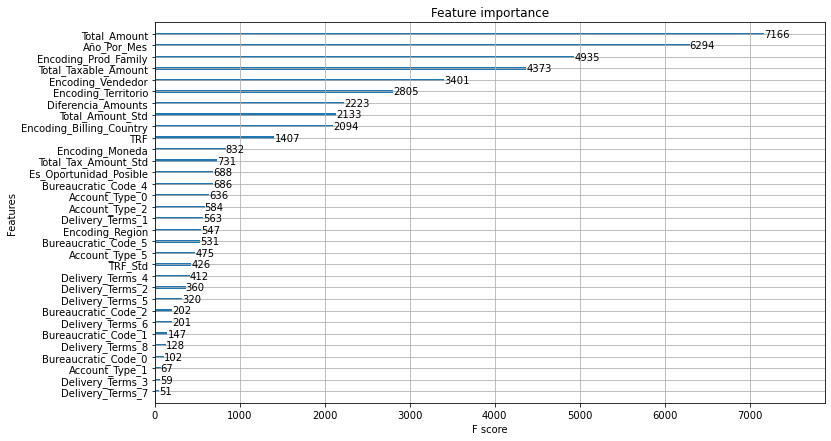

In [203]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

In [204]:
division_x_test = division_x_test.reset_index()
serie1 = pd.DataFrame(division_x_test['Opportunity_ID'])
serie2 = pd.DataFrame(promedio)
serie3 = pd.DataFrame(division_y_test)
serie3 = serie3.reset_index()
df_datos = pd.DataFrame(serie1)
df_datos['Target'] = serie2
df_datos.columns = ['Opportunity_ID', 'Target']
df_datos['Prediccion'] = df_datos['Target'].round()

,Opportunity_ID,Target,Prediccion,Stage
0,2383,0.453555,0.0,0
1,9084,0.781479,1.0,1
2,7527,0.810995,1.0,1
3,7080,0.269008,0.0,0
4,2137,0.518400,1.0,1
...,...,...,...,...
2083,4126,0.152744,0.0,0
2084,6722,0.329358,0.0,0
2085,2551,0.051368,0.0,0
2086,7127,0.382387,0.0,0


In [206]:
df_datos = df_datos.merge(serie3,on='Opportunity_ID')
acertados = df_datos[df_datos['Prediccion'] == df_datos['Stage']]
errados = df_datos[df_datos['Prediccion'] != df_datos['Stage']]

KeyError: 'Stage'

In [207]:
acertados

,Opportunity_ID,Target,Prediccion,Stage
0,2383,0.453555,0.0,0
1,9084,0.781479,1.0,1
2,7527,0.810995,1.0,1
3,7080,0.269008,0.0,0
4,2137,0.518400,1.0,1
...,...,...,...,...
2083,4126,0.152744,0.0,0
2084,6722,0.329358,0.0,0
2085,2551,0.051368,0.0,0
2086,7127,0.382387,0.0,0


In [208]:
errados

,Opportunity_ID,Target,Prediccion,Stage
5,7750,0.451880,0.0,1
9,8169,0.753371,1.0,0
16,4048,0.512503,1.0,0
17,1489,0.318076,0.0,1
21,1659,0.520679,1.0,0
...,...,...,...,...
2060,5541,0.725136,1.0,0
2062,2696,0.104357,0.0,1
2063,12391,0.591616,1.0,0
2074,9447,0.391299,0.0,1
